## Experiment 5.0

- Model: Encoder to get laten space
- Data: raw5s
- Data chunk : chunk before random to train and test set
- Participant: 4
- EEG frequnce: 0.1-1 Hz

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

from my_library import get_freer_gpu

===========================================
### 1. Loading Data

#### Load CSV

In [2]:
df = pd.read_csv("data/raw_data_5s/p4_beau_data_2020-11-16.csv")
df.head()

,timestamps,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Marker
0,15899.346,59013.145,60195.035,36726.801,14624.903,13694.892,64584.852,-13811.255,11368.209,-17991.299,64856.379,9063.342,-49394.738,67466.375,30180.777,59462.770,58583.273,0
1,15899.347,58981.426,60149.797,36715.469,14631.988,13672.405,64503.043,-13736.756,11448.966,-17982.918,64749.293,8994.565,-49371.516,67489.414,30112.023,59354.633,58601.984,0
2,15899.348,59017.727,60195.594,36757.957,14642.404,13687.180,64507.156,-13755.644,11409.738,-18032.404,64963.602,9162.137,-49294.312,67484.320,30274.029,59584.812,58665.617,0
3,15899.400,59039.922,60219.465,36752.863,14652.418,13689.326,64572.109,-13814.854,11375.809,-17992.596,64719.922,8961.217,-49372.836,67464.562,30068.885,59331.566,58552.922,0
4,15899.400,59044.055,60192.109,36732.699,14640.124,13647.148,64484.133,-13707.073,11470.603,-18004.643,64897.305,9116.472,-49255.824,67501.172,30237.307,59519.723,58673.531,0


We gonna drop the timestamps as they are not needed.  Markers will be the one indexing events, not timestamps.

In [3]:
df = df.drop(["timestamps"], axis=1)

Change channel name so they are recognizable

In [4]:
df.columns = ['Fp1', 'Fp2', 'F7', 'F3', 'F4', 'F8', 'C3', 'Cz', 'C4', 'T5', 'P3', 'P4',
           'T6', 'POz', 'O1', 'O2', 'Marker']   #channels named according to how we plug our eeg device
df.head()

,Fp1,Fp2,F7,F3,F4,F8,C3,Cz,C4,T5,P3,P4,T6,POz,O1,O2,Marker
0,59013.145,60195.035,36726.801,14624.903,13694.892,64584.852,-13811.255,11368.209,-17991.299,64856.379,9063.342,-49394.738,67466.375,30180.777,59462.770,58583.273,0
1,58981.426,60149.797,36715.469,14631.988,13672.405,64503.043,-13736.756,11448.966,-17982.918,64749.293,8994.565,-49371.516,67489.414,30112.023,59354.633,58601.984,0
2,59017.727,60195.594,36757.957,14642.404,13687.180,64507.156,-13755.644,11409.738,-18032.404,64963.602,9162.137,-49294.312,67484.320,30274.029,59584.812,58665.617,0
3,59039.922,60219.465,36752.863,14652.418,13689.326,64572.109,-13814.854,11375.809,-17992.596,64719.922,8961.217,-49372.836,67464.562,30068.885,59331.566,58552.922,0
4,59044.055,60192.109,36732.699,14640.124,13647.148,64484.133,-13707.073,11470.603,-18004.643,64897.305,9116.472,-49255.824,67501.172,30237.307,59519.723,58673.531,0


Let's look at how the marker was generated.  Here is the format:

- [block, trial, actual label] 
- actual label is 0 to 9, representing each character
- [-x, *, *] = rest between block x and x + 1 (4s)
- [0] = warmup

In [5]:
# print(df['Marker'].unique())

Since we set our marker to have three info: #block, #trial, and class.  We gonna split and get the class for the markers.   **Note that we shall reserve 0 for no event for raw mne, thus we shall represent class 0-9 using label 1-10.**

In [6]:
#use numpy as another view of the pandas columns for faster operation
marker_np = df['Marker'].values

for idx, marker in enumerate(marker_np):
    if "*" in marker:
        marker_np[idx] = 0
    elif "," in marker:
        #we reserved 0 for no event, so class 0-9 will be represented as 1-10 instead
        marker_np[idx] = int(marker.split(",")[-1]) + 1   
    else:
        marker_np[idx] = 0
    
#check whether df['Marker'] changed according to np
print(df['Marker'].unique())

[0 6 8 5 4 2 10 1 3 7 9]


Make sure we have 10 batch (this may vary according to your experiment) for each characters.  But for no events, it should be a lot.

In [7]:
print(df.groupby('Marker').nunique())

          Fp1     Fp2      F7     F3     F4      F8      C3     Cz      C4  \
Marker                                                                       
0       78794  114277  110006  77628  95902  107752  104073  92955  101659   
1          10      10      10     10     10      10      10     10      10   
2          10      10      10     10     10      10      10     10      10   
3          10      10      10     10     10      10      10     10      10   
4          10      10      10     10     10      10      10     10      10   
5          10      10      10     10     10      10      10     10      10   
6          10      10      10     10     10      10      10     10      10   
7          10      10      10     10     10      10      10     10      10   
8          10      10      10     10     10      10      10     10      10   
9          10      10      10     10     10      10      10     10      10   
10         10      10      10     10     10      10      10     

===========================================
### 2. Artifact Removal

Artifacts that are restricted to a narrow frequency range can sometimes be repaired by filtering the data. Two examples of frequency-restricted artifacts are slow drifts and power line noise. Here we illustrate how each of these can be repaired by filtering.

But first we gonna use Python MNE as it provides many useful methods for achieving these tasks.  So first, we gonna transform our pandas to mne type.  Here is the function transforming df to raw mne.

In [8]:
import mne
from mne import create_info
from mne.io import RawArray

def df_to_raw(df):
    sfreq = 125
    ch_names = list(df.columns)
    ch_types = ['eeg'] * (len(df.columns) - 1) + ['stim']
    ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')

    df = df.T  #mne looks at the tranpose() format
    df[:-1] *= 1e-6  #convert from uVolts to Volts (mne assumes Volts data)

    info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)

    raw = mne.io.RawArray(df, info)
    raw.set_montage(ten_twenty_montage)

    #try plotting the raw data of its power spectral density
    raw.plot_psd()

    return raw

Transform df to raw mne.

Creating RawArray with float64 data, n_channels=17, n_times=136164
    Range : 0 ... 136163 =      0.000 ...  1089.304 secs
Ready.
Effective window size : 16.384 (s)


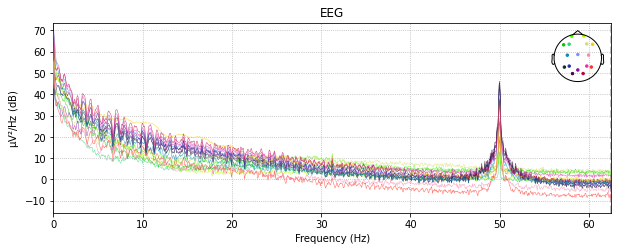

In [9]:
raw = df_to_raw(df)

#### 2.1 Power line noise

Some artifacts are restricted to certain frequencies and can therefore be fixed by filtering. An artifact that typically affects only some frequencies is due to the power line.

Power-line noise is a noise created by the electrical network. It is composed of sharp peaks at 50Hz (or 60Hz depending on your geographical location). Some peaks may also be present at the harmonic frequencies, i.e. the integer multiples of the power-line frequency, e.g. 100Hz, 150Hz, … (or 120Hz, 180Hz, …).

Remove the 50Hz power line noise in Thailand.  We will also be remove its harmonics, i.e., 100Hz, 150Hz, etc.  Since our signal is 62.5Hz (125Hz / 2 according to Nyquist Theorem), we don't need to run the harmonics but simply notch the 50Hz signal.

In [10]:
raw.notch_filter(50, filter_length='auto', phase='zero') #250/2 based on Nyquist Theorem

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 825 samples (6.600 sec)



<RawArray | 17 x 136164 (1089.3 s), ~17.7 MB, data loaded>

Effective window size : 16.384 (s)


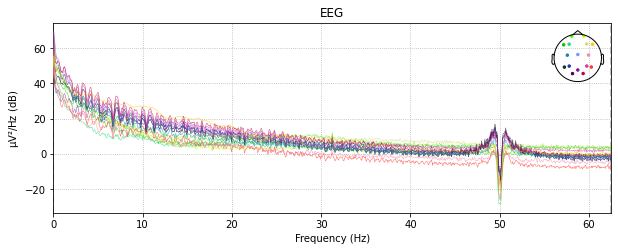

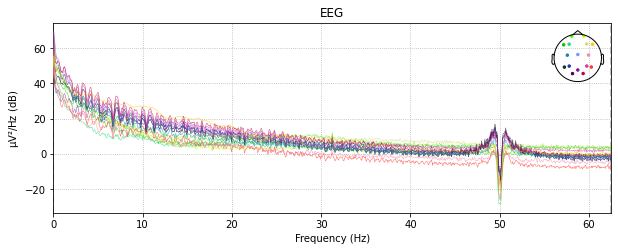

In [11]:
#observe that the 50Hz noise is now gone, yay!
raw.plot_psd()

#### 2.2 Slow drift

Low-frequency drifts in raw data can usually be spotted by plotting a fairly long span of data with the plot() method, though it is helpful to disable channel-wise DC shift correction to make slow drifts more readily visible. Here we plot 900 seconds (since we perform a 15 minutes experiment), showing all the eeg channels:

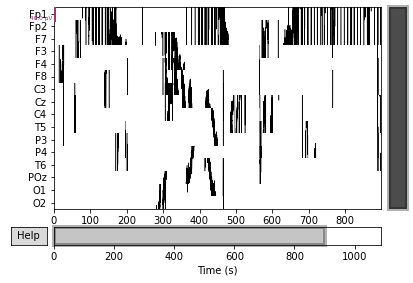

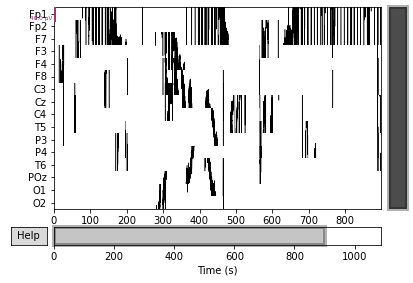

In [12]:
eeg_channels = mne.pick_types(raw.info, eeg=True)
raw.plot(duration=900, order=eeg_channels)

Notice that there are a lot of vertical black lines.  Those are drifts.  We can usually remove using low frequency high pass filter.  Here let's try 0.1, 0.2 and 1 Hz.

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 4125 samples (33.000 sec)



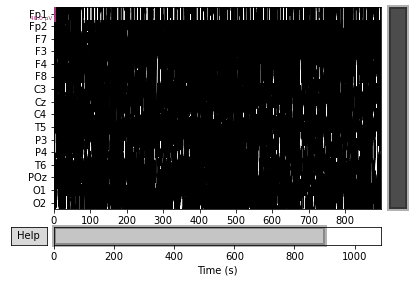

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Filter length: 2063 samples (16.504 sec)



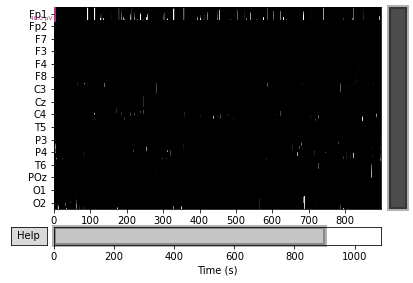

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 413 samples (3.304 sec)



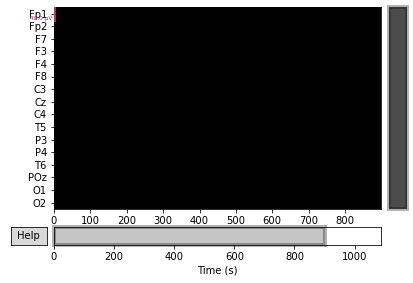

In [13]:
for cutoff in (0.1, 0.2, 1):
    raw_highpass = raw.copy().filter(l_freq=cutoff, h_freq=None)
    fig = raw_highpass.plot(duration=900, order=eeg_channels)
    fig.subplots_adjust(top=0.9)
    fig.suptitle('High-pass filtered at {} Hz'.format(cutoff), size='xx-large',
                 weight='bold')

Looks like 1Hz was quite quite good to fully remove the slow drifts. Usually, 1Hz is a good measure since most of the brain frequency lies around 1 to 40Hz.  Given that, we shall filter our brain signal to 1 to 40Hz.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 1 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.01, 1.00 Hz: -6.02, -6.02 dB

Effective window size : 16.384 (s)


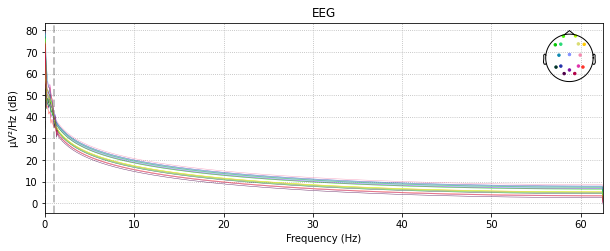

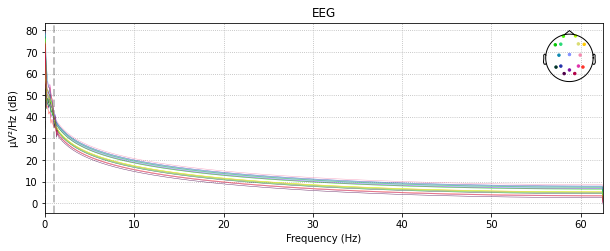

In [14]:
# raw.filter(1, 48, method='iir')
raw.filter(0.01, 1, method='iir')
raw.plot_psd()

===========================================
### 3. Epoching

Epoching is a process of extracting only the relevant EEG data when the event happens.  Here we shall extract -0.1 seconds before the event starts until 0.5 seconds after the event starts.  Here we choose 0.5 seconds because we knew that our stimuli stay on for 0.5 seconds after the event starts.

In [15]:
from mne import Epochs, find_events

def getEpochs(raw, event_id, tmin, tmax, picks):

    #epoching
    events = find_events(raw)
    
    #reject_criteria = dict(mag=4000e-15,     # 4000 fT
    #                       grad=4000e-13,    # 4000 fT/cm
    #                       eeg=100e-6,       # 150 μV
    #                       eog=250e-6)       # 250 μV

#     reject_criteria = dict(eeg=100e-6)  #most voltage in this range is not brain components

    epochs = Epochs(raw, events=events, event_id=event_id, 
                    tmin=tmin, tmax=tmax, baseline=None, preload=True,verbose=False, picks=picks)  #8 channels
    print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)

    return epochs

In [16]:
#this one requires expertise to specify the right tmin, tmax
event_id = {'0': 1, '1' : 2, '2': 3, '3':4, '4':5, '5':6, '6':7, '7':8, '8':9, '9':10}
tmin = 0 #0
tmax = 0.5 #0.5 seconds
picks  = eeg_channels

epochs = getEpochs(raw, event_id, tmin, tmax, picks)
# print(epochs.get_data())
print(picks)

100 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10]
sample drop %:  0.0
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


### 3.1 Select certain electodes

In [17]:
# picks  = eeg_channels[13:15]

Let's get our X and y in numpy form. Here X should have shape of (batch, channels, and samples) and y should have shape of (batch, ).   For the order of dimensions, we shall worry later on, depending on what deep learning libraries we use.

For calculate of samples, since we get 0.5 seconds after 0.1 seconds before, and our sampling rate is 125, thus the total sample is 0.6 * 125 = 75.

In [18]:
X = epochs.get_data()
y = epochs.events[:, -1]
y = y-1
print(X.shape)

(100, 16, 63)


In [19]:
### Plot to see wheter eegs have drift or not
data = X.reshape(-1,16)
print(data.shape)
# fig, ax = plt.subplots(16,1,figsize=(200,100),sharex=True)

# start_point = 3000
# plot_lenght = 4000

# for i in range(data.shape[1]):
#     ax[i].plot(range(plot_lenght),data[start_point:start_point+plot_lenght,i])

(6300, 16)


### 3.2 Chnuking 
- For X : Chunking eeg to lengh of 10 data point in each stimuli's eeg
- For y(lebels) : Filled the lebels in y because we chunk X ( 1 stimuli into 6 chunk). We have 500 labels before but now we need 500 x 6 = 3000 labels

In [20]:
chunk_size = 10 
print(f'Shape of X : {X.shape}')
print(f'Shape of y : {y.shape}')

Shape of X : (100, 16, 63)
Shape of y : (100,)


In [21]:
import sys
np.set_printoptions(threshold=sys.maxsize)

X = epochs.get_data()
y = epochs.events[:, -1]
y = y-1

def chunk_data(data, size):
    data_keep = data.shape[2] - (data.shape[2]%size)
    #print(f'{data.shape}')
    data      = data[:,:,:data_keep]
    #print(f'{data.shape}')
    #print(data[0,0,:20])
    data      = data.reshape(-1,data.shape[1],data.shape[2]//size,size)
    #print(f'{data.shape}')
    #print(data[0,0,:2,:])
    data      = np.transpose(data, (0, 2, 1, 3)  )
    #print(f'{data.shape}')
    #print(data[0,:2,0,:])
    
    return data

def filled_y(y   , chunk_num):
    yy = np.array(  [ [ i ] *chunk_num for i in  y     ] ).ravel()

    return yy



print(f'Oringinal X shape {X.shape}')
X_chunk = chunk_data(X, chunk_size)
X       = X_chunk
print(f'Reshape X to : {X.shape}')
chunk_per_stim = X.shape[1]
X       = X.reshape(-1,16,10)
print(f'Reshpae X to : {X.shape}')



print(f'Shape of y : {y.shape}')
y   = filled_y(y , chunk_per_stim)
print(f'Shape of new y : {y.shape}')
print(np.unique(y))

Oringinal X shape (100, 16, 63)
Reshape X to : (100, 6, 16, 10)
Reshpae X to : (600, 16, 10)
Shape of y : (100,)
Shape of new y : (600,)
[0 1 2 3 4 5 6 7 8 9]


===========================================
### 4. Define Model

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import fnmatch

In [23]:
class EEGEncoder(nn.Module):
    '''
    Expected Input Shape: (batch, channels, height , width)
                          (64   , 16      , 1      , 63   )
    '''
    def __init__(self):
        super().__init__()
        
        self.activation = nn.Tanh()
        
        self.conv1 = nn.Sequential(    nn.Conv1d(16, 32, kernel_size=(1,3),   padding=(0,0), stride=(1,1))  ,  self.activation )
        self.conv2 = nn.Sequential(    nn.Conv1d(32, 64, kernel_size=(1,3) ,  padding=(0,0), stride=(1,1))  ,  self.activation )
        self.fc1   = nn.Sequential(    nn.Linear(384,256),  self.activation ,nn.Dropout(0.1)   ,nn.BatchNorm1d(256)   )
        self.fc2   = nn.Sequential(    nn.Linear(256,128),  self.activation ,nn.Dropout(0.1)   ,nn.BatchNorm1d(128) )
        self.fc3   = nn.Sequential(    nn.Linear(128,64),  self.activation  ,nn.Dropout(0.1)   ,nn.BatchNorm1d(64) )
        self.fc4   = nn.Sequential(    nn.Linear(64,32),  self.activation   ,nn.Dropout(0.1)   ,nn.BatchNorm1d(32) )
        self.fc5   = nn.Sequential(    nn.Linear(32,10)   )

        
        
    
        self.is_debug= False
        
    def encode(self, X):
        
        
        if self.is_debug  : print('--------Convolute--------'); print(X.shape) 
            
        X = self.conv1(X)
        if self.is_debug  : print(X.shape) 
            
        X = self.conv2(X)
        if self.is_debug  : print(X.shape) 
            
        X = X.flatten(start_dim = 1)
        if self.is_debug  : print('--------Flatten--------') ; print(X.shape) 
 
        X = self.fc1(X)
        if self.is_debug : print('--------Flatten--------') ; print(X.shape) 

        X = self.fc2(X)
        if self.is_debug  : print(X.shape) 

        X = self.fc3(X)
        if self.is_debug  : print(X.shape) 
        
        X = self.fc4(X)
        if self.is_debug  : print(X.shape) 

        X = self.fc5(X)
        if self.is_debug  : print(X.shape) 

            
        return X
        
    def forward(self,X):
        X = self.encode(X)
        return X
    
    def get_latent( self, X):
        if self.is_debug  : print('--------Convolute--------'); print(X.shape) 
            
        X = self.conv1(X)
        if self.is_debug  : print(X.shape) 
            
        X = self.conv2(X)
        if self.is_debug  : print(X.shape) 
            
        X = X.flatten(start_dim = 1)
        if self.is_debug  : print('--------Flatten--------') ; print(X.shape) 
 
        X = self.fc1(X)
        if self.is_debug : print('--------Flatten--------') ; print(X.shape) 

        X = self.fc2(X)
        if self.is_debug  : print(X.shape) 

        X = self.fc3(X)
        if self.is_debug  : print(X.shape) 
        
        X = self.fc4(X)
        if self.is_debug  : print(X.shape) 
        
        return X
    
    def classifier(self, latent):
        return self.fc5(latent)
    
# torch_X = torch.from_numpy(X)
# torch_X1 = torch_X.reshape(torch_X.shape[0],torch_X.shape[1],1,torch_X.shape[2]).float()
# model_AE = AE()
# model_AE.is_debug = True
# model_AE.forward(torch_X1)


===========================================
### 5. Defind Training function

Define the training process

We set `model.train()` so dropout is applied.

In [24]:
def train(model, iterator, optimizer, criterion):
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    predicted_list = []
    model.train()
    
    for batch, labels in iterator:
        
        #Move tensors to the configured device
        batch  = batch.to(device)
        labels = labels.to(device)
       
        
        #Forward pass
        outputs = model(batch.float())
        outputs = outputs.to(device)
        
        loss = criterion(outputs, labels).to(device)

        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
        #check accuracy
        predictions = model(batch.float())
        _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
        total += labels.size(0)  #keep track of total
        correct += (predicted == labels).sum().item()  #.item() give the raw number
        acc = 100 * (correct / total)
                
        epoch_loss += loss.item()
        epoch_acc = acc
        predicted_list.append(predicted)
        
    return epoch_loss / len(iterator), epoch_acc, predicted_list


def evaluate(model, iterator, criterion):
    
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    predicted_list = []
    labels_list    = []
        
    model.eval()
    
    with torch.no_grad():
    
        for batch, labels in iterator:
            
            #Move tensors to the configured device
            batch = batch.to(device)
            labels = labels.to(device)
            
            #print(labels)
            

            predictions = model(batch.float())
            loss = criterion(predictions, labels)
            
            
            _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
            #print(predicted)
            
            total += labels.size(0)  #keep track of total
            correct += (predicted == labels).sum().item()  #.item() give the raw number
            acc = 100 * (correct / total)
            
            epoch_loss += loss.item()
            epoch_acc += acc
            
            labels_list.append(labels)
            predicted_list.append(predicted)
           

    return epoch_loss / len(iterator), epoch_acc / len(iterator) ,predicted_list, labels_list


# define a time function useful for calculating time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs



def do_plot(d_losses, g_losses):
    plt.figure(figsize=(25,5))
#     clear_output(wait=True)
    plt.plot(d_losses, label='Discriminator')
    plt.plot(g_losses, label='Generator')
    plt.title('GAN loss')
    plt.legend()
    plt.show()

===========================================
### 6. Actual Training for Feature Extraction 


#### 6.1 Define model parameters
- Count model parameters
- optimizer
- loss function
- GPU

In [25]:
#Create the model from class
model_EEGEncoder = EEGEncoder()
model_EEGEncoder = model_EEGEncoder.float() #define precision as float to reduce running time
models   = [model_EEGEncoder]


#Count the parameters for writing papers
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

for model in models:
    print(f'The model {type(model).__name__} has {count_parameters(model):,} trainable parameters')# Train the model


The model EEGEncoder has 150,858 trainable parameters


#### 6.2 Prepare X and y in correct shape

- For X, pytorch (if set batch_first) LSTM requires to be (batch, seq_len, features).  Thus, for us, it should be (100, 75, 16).
- For y, nothing is special
- So let's convert our numpy to pytorch, and then reshape using view

In [26]:
torch_X = torch.from_numpy(X)
torch_y = torch.from_numpy(y)

torch_X = torch_X


print(torch_X.shape)
print(torch_y.shape)

torch.Size([600, 16, 10])
torch.Size([600])


In [27]:
print("Original X: ", torch_X.size())

Original X:  torch.Size([600, 16, 10])


CNN requires the input shape as (batch, channel, height, width)

In [28]:
torch_X_reshaped = torch_X.reshape(torch_X.shape[0],torch_X.shape[1],1,torch_X.shape[2])
print("Converted X to ", torch_X_reshaped.size())

Converted X to  torch.Size([600, 16, 1, 10])


#### 6.3 Split test train set, and load them into a DataLoader

In [29]:
from torch.utils.data import TensorDataset

# Define dataset
ds = TensorDataset(torch_X_reshaped, torch_y)

#Train test split
train_size = int(torch_X_reshaped.size()[0] * 0.7)
valid_size = int(torch_X_reshaped.size()[0] * 0.2)
test_size  = int(torch_X_reshaped.size()[0] * 0.1)

train_set, valid_set, test_set = torch.utils.data.random_split(ds, [train_size, valid_size, test_size])



BATCH_SIZE = 128 #keeping it binary so it fits GPU
#Train set loader
train_iterator = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)
#Validation set loader
valid_iterator = torch.utils.data.DataLoader(dataset=valid_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

#Test set loader
test_iterator = torch.utils.data.DataLoader(dataset=test_set, 
                                          batch_size=test_size, 
                                          shuffle=True)


#### 6.4 Train the model

In [30]:
import torch.optim as optim

device = torch.device(get_freer_gpu() if torch.cuda.is_available() else 'cpu')
print("Configured device: ", device)

best_valid_loss = float('inf')
train_losses    = []
valid_losses    = []

learning_rate = 0.001
N_EPOCHS      = 10000          ## best is 10k
criterion     = nn.CrossEntropyLoss()
optimizer     = torch.optim.Adam(model.parameters(), lr=learning_rate)


for model in models:
    model = model.to(device)
criterion = criterion.to(device)


Configured device:  cuda:0


Epoch: 10000/10000  |	Train Loss: 0.11995  | Train Acc: 97.86%  |	 Val. Loss: 1.70099  | Val. Acc: 65.00%


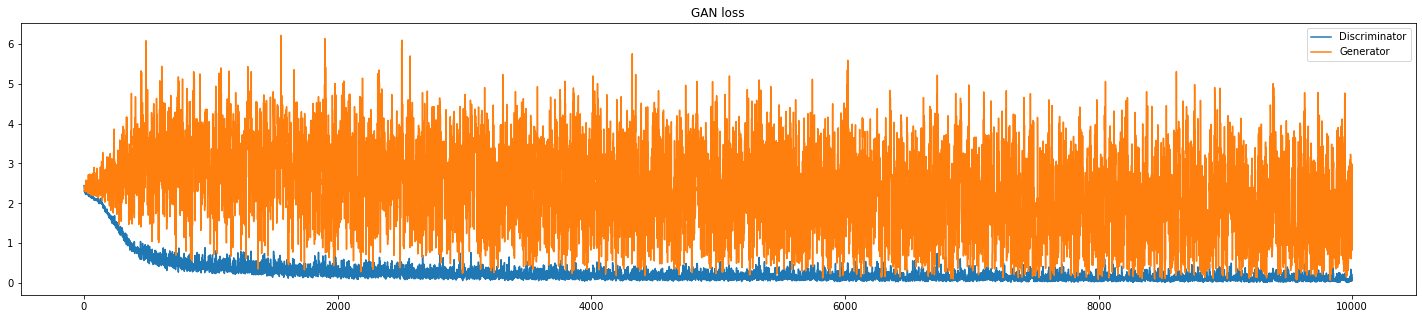

In [31]:
model.is_debug=False
iteration = 0

for i, model in enumerate(models):
    print(f"Training {type(model).__name__}")
    
    start_time = time.time()

    for epoch in range(N_EPOCHS):
        start_time = time.time()

        train_loss, train_acc, train_predicted    = train(model, train_iterator, optimizer, criterion)
        valid_loss, valid_acc, valid_predicted, _ = evaluate(model, valid_iterator, criterion)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        iteration     += 1
        
        if (epoch+1) % 50 == 0:
            clear_output(wait=True)
            print(f'Epoch: {epoch+1:02}/{N_EPOCHS}  |',end='')
            print(f'\tTrain Loss: {train_loss:.5f}  | Train Acc: {train_acc:.2f}%  |', end='')
            print(f'\t Val. Loss: {valid_loss:.5f}  | Val. Acc: {valid_acc:.2f}%')
            do_plot(train_losses, valid_losses)
            
                    #--------- Display loss---------
#         if batch_i % print_every == 0:
#             clear_output(wait=True)
#             print('Epoch : {:1d}/{:1d} | Total iteration : {:1d} | d_loss: {:6.6f} | g_loss: {:6.6f}'.format(epoch+1, NUM_EPOCH, iteration, d_loss.item(), g_loss.item()))
            

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            print("Model:{} saved.".format(type(model).__name__))
            torch.save(model.state_dict(), f'save/{type(model).__name__}{i}_dict_5s.pt.tar')
            best_model_index = i


### 7. Evaluation (Test model)
using test set

In [32]:
def squeeze_to_list(_tmp):
    from functools import reduce
    import operator

    xx     = [ i.cpu().detach().numpy().ravel().tolist() for i in _tmp]
    xx     = reduce(operator.concat, xx)
    return xx



models[best_model_index].load_state_dict(torch.load(f'save/{type(model).__name__}{i}_dict_5s.pt.tar'))



# test_loss = evaluate(models[best_model_index], test_iterator, criterion)
# print(f'Test Loss: {test_loss}') # | Test Acc: {test_acc:.2f}%')

test_loss, test_acc , predicted, actual_labels = evaluate(models[best_model_index], test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}%')
print("---------------")
print(" (Actual y , Predicted y)")

y_test     = squeeze_to_list(actual_labels)
y_hat_test = squeeze_to_list(predicted)

out = zip(y_test, y_hat_test)

print(list(out))




Test Loss: 0.074 | Test Acc: 98.33%
---------------
 (Actual y , Predicted y)
[(4, 4), (5, 5), (8, 8), (0, 0), (6, 6), (9, 9), (4, 4), (2, 2), (4, 4), (3, 3), (2, 2), (6, 6), (6, 6), (7, 7), (7, 7), (9, 9), (3, 3), (7, 7), (6, 6), (2, 2), (7, 7), (2, 2), (6, 6), (4, 4), (4, 4), (5, 5), (2, 2), (2, 2), (0, 0), (9, 9), (5, 5), (4, 4), (4, 4), (3, 3), (2, 2), (3, 3), (6, 6), (8, 8), (0, 0), (7, 7), (3, 3), (0, 0), (0, 0), (4, 4), (0, 0), (5, 5), (5, 5), (2, 2), (5, 5), (6, 6), (2, 2), (6, 6), (5, 5), (9, 9), (8, 8), (7, 7), (3, 3), (5, 5), (8, 8), (4, 3)]


### 8. Save features extracted

In [33]:

# encoder_best_model = models[best_model_index].load_state_dict(torch.load(f'save/{type(model).__name__}{i}.pth.tar'))
# torch.save(encoder_best_model, 'save/7.1_encoder_best_model.pth.tar')


### save Encoder network
torch.save(model_EEGEncoder, 'save/model_EEGEncoder_network_5s.pt.tar')
torch.save(test_iterator,'save/eeg_X_test_5s.pt.tar')


# save extracted features
eeg_encode = model_EEGEncoder.get_latent(torch_X_reshaped.to(device).float())
eeg_extracted_features = eeg_encode.detach().cpu().numpy()
np.save('save/eeg_features_5s.npy',eeg_extracted_features )
np.save('save/eeg_encoder_y_5s.npy',y )

/archive/gpu/home/jakrapop.a/.conda/envs/jakrapop_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type EEGEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/archive/gpu/home/jakrapop.a/.conda/envs/jakrapop_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Tanh. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/archive/gpu/home/jakrapop.a/.conda/envs/jakrapop_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/archive/gpu/home/jakrapop.a/.conda/envs/jakrapop_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retriev